<a href="https://colab.research.google.com/github/wLennyw/analysis-theLook_eCommerce/blob/main/%5BData_Analytics%5D-Ecommerce_theLook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

- Auth Google Colab and Bigquery.
- Import Python packages.


In [ ]:
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns

%reload_ext google.colab.data_table
auth.authenticate_user()
print("Authenticated.")

project_id = 'fp-thelook'
client = bigquery.Client(project=project_id)

Authenticated.


# **Overview of the Dataset**

In [ ]:
# @title 1. Identify table schema: There are six tables in theLook dataset, with primary and foreign keys identified by the 'id' field.

%%bigquery --project $project_id

-- Extract dataset schema

SELECT DENSE_RANK() OVER(ORDER BY table_name) AS table_no,
  table_name,
  ordinal_position,
  column_name,
  data_type,
  is_nullable,
  column_default
FROM `bigquery-public-data.thelook_ecommerce.INFORMATION_SCHEMA.COLUMNS`
ORDER BY table_name, ordinal_position

Query is running:   0%|          |

Downloading:   0%|          |

,table_no,table_name,ordinal_position,column_name,data_type,is_nullable,column_default
0,1,distribution_centers,1,id,INT64,YES,NULL
1,1,distribution_centers,2,name,STRING,YES,NULL
2,1,distribution_centers,3,latitude,FLOAT64,YES,NULL
3,1,distribution_centers,4,longitude,FLOAT64,YES,NULL
4,1,distribution_centers,5,distribution_center_geom,GEOGRAPHY,YES,NULL
...,...,...,...,...,...,...,...
70,7,users,12,latitude,FLOAT64,YES,NULL
71,7,users,13,longitude,FLOAT64,YES,NULL
72,7,users,14,traffic_source,STRING,YES,NULL
73,7,users,15,created_at,TIMESTAMP,YES,NULL


In [ ]:
# @title 2. Preliminary data validation: No missing or duplicate values were found in the primary key data.

%%bigquery --project $project_id

-- Create 2 variables to
-- (1) hold extracted table/column names in array
-- (2) hold dynamic query to count data in multiple tables & columns

DECLARE dynamic_sql STRING;
DECLARE column_list
  ARRAY<STRUCT<
    table_name STRING,
    column_name STRING,
    ordinal_position INT64
  >>;

-- Step 1: Extract tables and column names to check
SET column_list = (
  SELECT ARRAY_AGG(STRUCT(
    table_name,
    column_name,
    ordinal_position
))
  FROM `bigquery-public-data.thelook_ecommerce.INFORMATION_SCHEMA.COLUMNS`
  WHERE table_name LIKE "%"
    AND (ordinal_position = 1
      OR column_name LIKE "%id")
);

-- Step 2: Check row count and row with unique value count
SET dynamic_sql = (
  SELECT STRING_AGG(
    FORMAT("""
      SELECT
        '%s' AS table_name,
        '%s' AS column_name,
        '%i' AS ordinal_position,
        COUNT(DISTINCT `%s`) AS distinct_count,
        COUNT(`%s`) AS ttl_count,
        COUNT(`%s`) - COUNT(DISTINCT `%s`) AS ttl_vs_distinct_count
      FROM `bigquery-public-data.thelook_ecommerce.%s`
    """,
    col.table_name,
    col.column_name,
    col.ordinal_position,
    col.column_name,
    col.column_name,
    col.column_name,
    col.column_name,
    col.table_name
    )
    , " UNION ALL ")
  FROM UNNEST(column_list) AS col
);

-- Step 3: Sort
SET dynamic_sql = CONCAT(dynamic_sql, " ORDER BY ordinal_position, table_name, distinct_count DESC");

EXECUTE IMMEDIATE dynamic_sql;

Query is running:   0%|          |

Downloading:   0%|          |

,table_name,column_name,ordinal_position,distinct_count,ttl_count,ttl_vs_distinct_count
0,distribution_centers,id,1,10,10,0
1,events,id,1,2417924,2417924,0
2,inventory_items,id,1,487993,487993,0
3,order_items,id,1,180624,180624,0
4,orders,order_id,1,124795,124795,0
5,products,id,1,29120,29120,0
6,users,id,1,100000,100000,0
7,inventory_items,product_distribution_center_id,12,10,487993,487983
8,events,user_id,2,80141,1293071,1212930
9,inventory_items,product_id,2,29046,487993,458947


In [ ]:
# @title 2. Data availability: The data ranges from Jan 2019 to mid-Jun 2025 (as of 12-Jun-2025). For this analysis, we'll focus on data from 01-Jan-2020 to 31-May-2025.

%%bigquery --project $project_id

SELECT EXTRACT(year FROM created_at) AS order_year,
  MAX(EXTRACT(month FROM created_at)) AS ttl_month,
  COUNT(DISTINCT order_id) AS order_cnt,
  ROUND(MIN(sale_price),2) AS min_price,
  ROUND(MAX(sale_price),2) AS max_price
FROM `bigquery-public-data.thelook_ecommerce.order_items`
WHERE status NOT IN ('CANCELLED')
GROUP BY 1
ORDER BY 1

Query is running:   0%|          |

Downloading:   0%|          |

,order_year,ttl_month,order_cnt,min_price,max_price
0,2019,12,1549,1.95,903.0
1,2020,12,5063,1.50,999.0
2,2021,12,9442,0.02,999.0
3,2022,12,15100,1.75,950.0
4,2023,12,22964,0.02,999.0
5,2024,12,37488,0.02,999.0
6,2025,6,33868,0.02,999.0


# **Analysis: 1. Sales and Profitability**

In [ ]:
# @title [Extract to data frame] Monthly sales

%%bigquery df --project $project_id

SELECT
  DATE(DATE_TRUNC(oi.created_at, MONTH)) AS order_month,
  SUM(oi.sale_price) AS total_revenue,
  SUM(p.cost) AS total_cost,
  SUM(oi.sale_price) - SUM(p.cost) AS total_profit,
  (SUM(oi.sale_price) - SUM(p.cost))/SUM(oi.sale_price)*100 AS profit_margin,
  COUNT(DISTINCT user_id) AS total_customers,
  COUNT(DISTINCT oi.order_id) AS total_orders,
  SUM(oi.sale_price) / COUNT(DISTINCT oi.order_id) AS avg_order_value,
  COUNT(DISTINCT p.id) AS product_cnt,
  COUNT(DISTINCT p.category) AS category_cnt,
  COUNT(DISTINCT p.brand) AS brand_cnt,
  COUNT(DISTINCT p.department) AS department_cnt,
FROM `bigquery-public-data.thelook_ecommerce.order_items` AS oi
LEFT JOIN `bigquery-public-data.thelook_ecommerce.products` AS p ON p.id = oi.product_id
WHERE status NOT IN ("Cancelled", "Returned")
  AND oi.created_at BETWEEN "2020-01-01" AND "2025-05-31"
GROUP BY 1
ORDER BY order_month

Query is running:   0%|          |

Downloading:   0%|          |

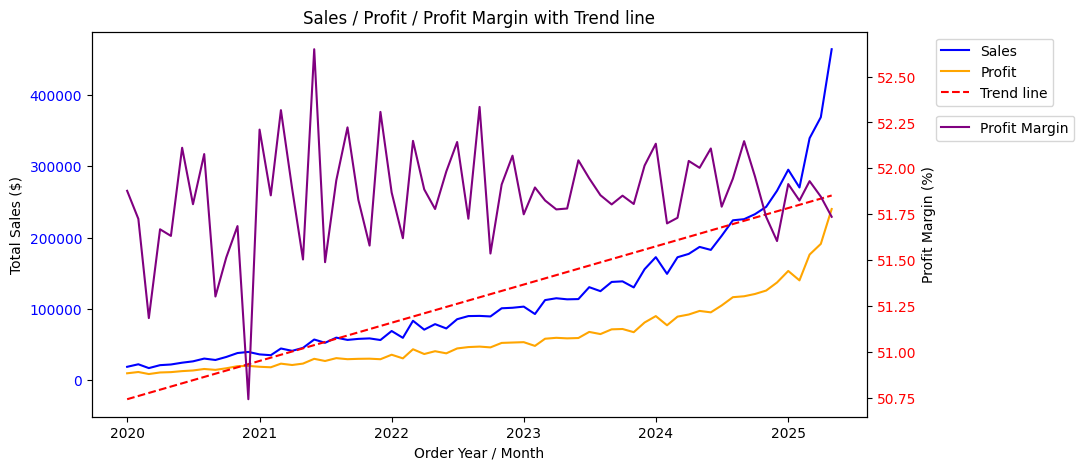

In [ ]:
# @title 1.1 Sales (blue line) and profitability (yellow line) are trending upward: Despite flat profit margin averaging at 52%, growth in sales is expected to continue.

# Define 2-axis chart size
fig, ax1 = plt.subplots(figsize=(10,5))

# Axis 1: Total revenue and profit
ax1.set_xlabel("Order Year / Month")
ax1.set_ylabel("Total Sales ($)")
ax1.plot(df['order_month'], df['total_revenue'], color="blue", label="Sales")
ax1.plot(df['order_month'], df['total_profit'], color="orange", label="Profit")

# Axis 2: Profit margin %
ax2 = ax1.twinx()
ax2.set_ylabel("Profit Margin (%)")
ax2.plot(df['order_month'], df['profit_margin'], color="purple", label="Profit Margin")
ax2.tick_params(axis='y', labelcolor="red")

# Set trendline
x_num = dates.date2num(df['order_month'])
trend = np.polyfit(x_num, df['total_revenue'], 1)
fit = np.poly1d(trend)

# Add trendline to axis 1
x_fit = np.linspace(x_num.min(), x_num.max())
ax1.plot(dates.num2date(x_fit), fit(x_fit), "r--", label='Trend line')
ax1.tick_params(axis='y', labelcolor="blue")

# Format chart
ax1.legend(bbox_to_anchor=(1.08, 1), loc='upper left')
ax2.legend(bbox_to_anchor=(1.08, 0.8), loc='upper left')

plt.title("Sales / Profit / Profit Margin with Trend line")
plt.show()

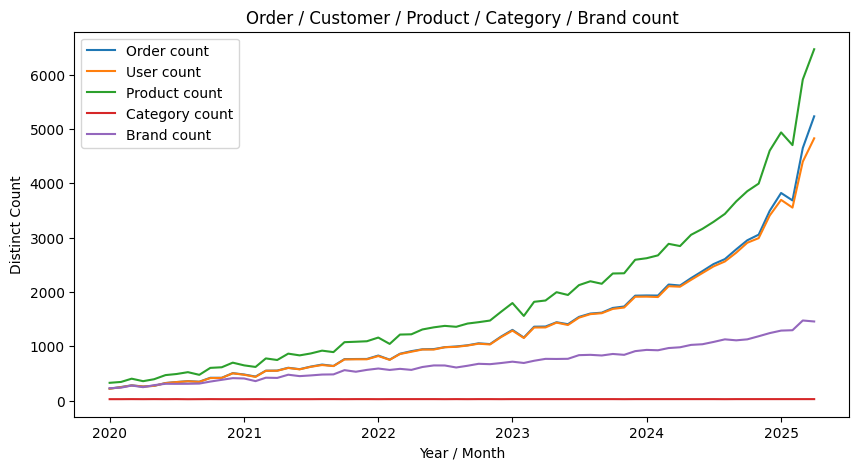

In [ ]:
# @title 1.2 Sales growth is driven by the expansion of brands and a significant increase in product range that attracted more customers.

# Define chart size
plt.figure(figsize=(10,5))

# Plot x / y data
plt.plot(df['order_month'], df['total_orders'], label='Order count')
plt.plot(df['order_month'], df['total_customers'], label='User count')
plt.plot(df['order_month'], df['product_cnt'], label='Product count')
plt.plot(df['order_month'], df['category_cnt'], label='Category count')
plt.plot(df['order_month'], df['brand_cnt'], label='Brand count')

# Format chart
plt.xlabel("Year / Month")
plt.ylabel("Distinct Count")
plt.title("Order / Customer / Product / Category / Brand count")

plt.legend();
plt.show();

# **Analysis: 2. Customers Behaviour**

In [ ]:
# @title [Extract to data frame] Customers purchase behaviour. For this analysis, we'll remove any outliers to ensure data accuracy and avoid skewed insights.

%%bigquery df --project $project_id

WITH order_items AS (
  SELECT *
  FROM `bigquery-public-data.thelook_ecommerce.order_items`
  WHERE status NOT IN ('Cancelled', 'Returned')
    AND created_at BETWEEN '2020-01-01' AND '2025-05-31'
),

cleaned_order_items AS (
  SELECT *
  FROM (
    SELECT oi.*,
      (oi.sale_price - s.aov) / s.std_val AS zs
    FROM order_items oi
    CROSS JOIN (
      SELECT AVG(sale_price) AS aov,
        STDDEV(sale_price) AS std_val
      FROM order_items oi
    ) AS s
  )
  WHERE ABS(zs) < 3
)

SELECT EXTRACT(YEAR FROM oi.created_at) AS order_year,
  FORMAT_TIMESTAMP("%Y-%m",oi.created_at) AS order_month,
  oi.order_id,
  oi.sale_price AS order_price,
  oi.product_id,
  p.category,
  p.brand,
  p.department,
  u.id AS user_id,
  u.age,
  u.gender,
  u.country,
  u.traffic_source,
  FORMAT_TIMESTAMP("%Y-%m",u.created_at) AS registered_month,
  oi1.first_order_date,
  oi1.last_order_date,
  DATE_DIFF(DATE('2025-05-31'),DATE(oi1.last_order_date), DAY) AS recency,
  DATE_DIFF(oi1.first_order_date, u.created_at, DAY) AS conv_day,
  oi1.total_order,
  oi1.total_spend,
  IF(oi1.total_order_month = 1, "NEW", "EXISTING") AS cust_type
FROM cleaned_order_items AS oi
LEFT JOIN `bigquery-public-data.thelook_ecommerce.products` AS p ON p.id = oi.product_id
LEFT JOIN `bigquery-public-data.thelook_ecommerce.users` AS u ON oi.user_id = u.id
LEFT JOIN (
  SELECT DISTINCT user_id,
    MIN(created_at) AS first_order_date,
    MAX(created_at) AS last_order_date,
    COUNT(DISTINCT order_id) AS total_order,
    SUM(sale_price) AS total_spend,
    COUNT(DISTINCT DATE_TRUNC(created_at,MONTH)) AS total_order_month
  FROM `bigquery-public-data.thelook_ecommerce.order_items`
  WHERE created_at <= "2025-05-31"
  GROUP BY 1
) oi1 ON oi1.user_id = u.id
ORDER BY user_id, order_id, product_id

Query is running:   0%|          |

Downloading:   0%|          |

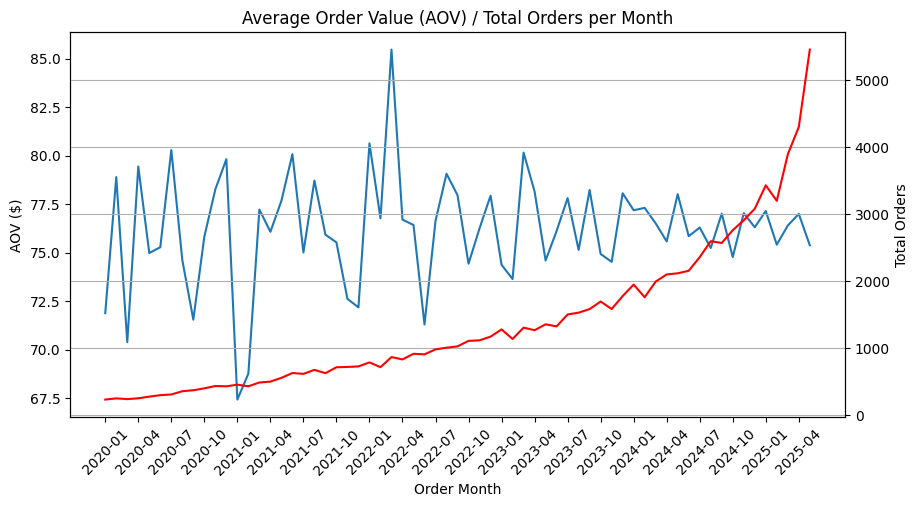

In [ ]:
# @title 2.1 Customers in average spent around $78 per order
# @markdown **Key Insights:**
# @markdown <li> AOV is ranging between 72-85 with no significant trend
# @markdown <li> Total orders is on uptrend with AOV stabilizing which might be driven by the increase of similar customer type.

# @markdown **Recommendations:**
# @markdown <li> Considering product bundling / upselling to increase AOV

# Define 2-axis chart size
fig,ax1=plt.subplots(figsize = (10,5))

# Group by unique orders
df_order = df.groupby(['order_month','order_id']).agg(
    order_price = ('order_price', 'sum')
).reset_index()

# Get total revenue and order count per month
monthly_total = df_order.groupby('order_month').agg(
    revenue = ('order_price', 'sum'),
    orders = ('order_id', 'count')
).reset_index()

# Get monthly aov
monthly_total['aov'] = monthly_total['revenue'] / monthly_total['orders']

# Axis 1: AOV
ax1.plot(monthly_total['order_month'], monthly_total['aov'])
ax1.set_xlabel('Order Month')
ax1.set_ylabel('AOV ($)')
xtick_labels = monthly_total['order_month']
ax1.set_xticks(ticks=range(0, len(xtick_labels), 3), labels=xtick_labels[::3], rotation=45)

# Axis 2: Total order count
ax2=ax1.twinx()
ax2.plot(monthly_total['order_month'], monthly_total['orders'], color='red')
ax2.set_ylabel('Total Orders')

# Format chart
plt.title('Average Order Value (AOV) / Total Orders per Month')
plt.grid(True)
plt.show()

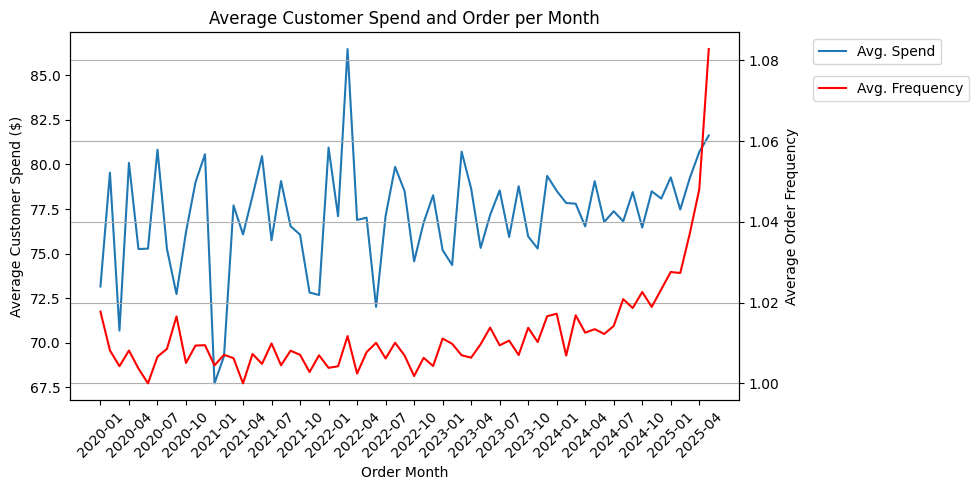

In [ ]:
# @title 2.2 Significant increase in order frequency since mid 2024

# @markdown **Key Insights:**
# @markdown <li> Order frequency rose from 1.02 to 1.08, increasing steadily since 2024 and spiking in 2025.
# @markdown <li> Total customer spend is stablizing at an average of \$70-$80 with a slight increase in the past few months.

# @markdown **Recommendations:**
# @markdown <li> Understand the driver of increase in order frequency, especially in 2025.
# @markdown <li> Consider to segment customers based on their shopping behaviours


# Define 2-axis chart size
fig, ax1 = plt.subplots(figsize=(10,5))

# Get unique orders and customers
df_orders = df.groupby(['order_month','order_id','user_id']).agg (
    revenue = ('order_price', 'sum')
).reset_index()

# Get total monthly orders and revenue
monthly_total = df_orders.groupby('order_month').agg(
    orders = ('order_id', 'count'),
    customers = ('user_id', 'nunique'),
    revenue = ('revenue', 'sum')
).reset_index()

# Get average customer spend per month
monthly_total['avg_spend'] = monthly_total['revenue'] / monthly_total['customers']

# Axis 1: Average customer spend per month
ax1.plot(monthly_total['order_month'], monthly_total['avg_spend'], label="Avg. Spend")
ax1.set_xticks(ticks=range(0,len(monthly_total['order_month']),3), labels=monthly_total['order_month'][::3], rotation=45)

# Axis 2: Average customer order per month
ax2 = ax1.twinx()
monthly_total['avg_freq'] = monthly_total['orders'] / monthly_total['customers']
ax2.plot(monthly_total['order_month'], monthly_total['avg_freq'], color='red', label='Avg. Frequency')

# Format chart
ax1.set_xlabel('Order Month')
ax1.set_ylabel('Average Customer Spend ($)')
ax2.set_ylabel('Average Order Frequency')
ax1.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 0.9))
ax1.set_title('Average Customer Spend and Order per Month')
plt.tight_layout()
plt.grid(True)
plt.show()

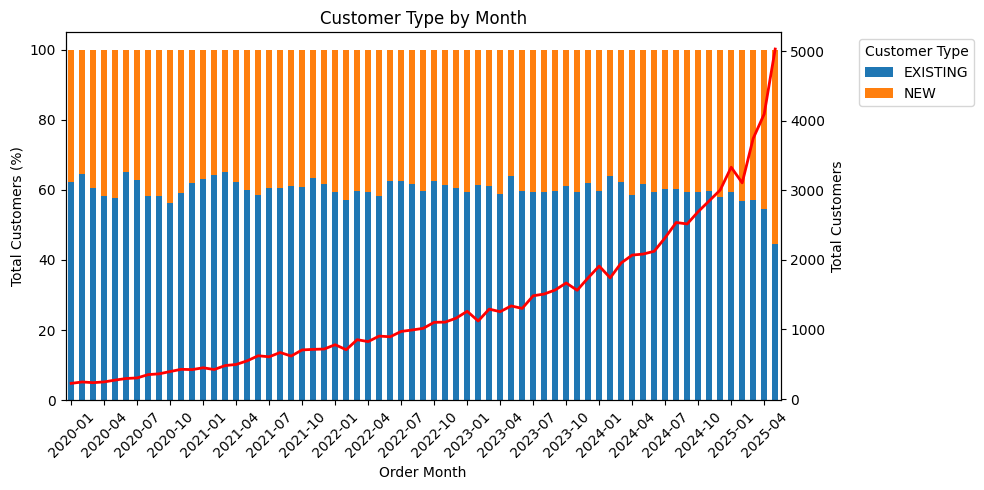

In [ ]:
# @title 2.3 Customer growth is on uptrend with significant increased in new customers (bought 1st time).

# @markdown **Key Insights:**
# @markdown <li> Total customers (red line) grown significantly in 2025 to reach 5k in May 2025 from 3k in Dec 2024.
# @markdown <li> New customers surge but slower returning customers is seen in 2025.

# @markdown **Recommendations:**
# @markdown <li> Identify the factor of massive increase in new customers.
# @markdown <li> Look into strategy to balance the acquisition and retetion.

# Define 2-axis chart size
fig, ax1 = plt.subplots(figsize=(10,5))

# Group customer type by month
df_cust_type = df.groupby(['order_month','cust_type']).agg(
    total_user = ('user_id','nunique')
).reset_index()

# Pivot data by order month and percentage of total per month
df_cust_type = df_cust_type.pivot(index = 'order_month', columns = 'cust_type', values = 'total_user')
df_cust_type_pct = df_cust_type.div(df_cust_type.sum(axis=1), axis=0) * 100

# Axis 1: % of customer type per month
df_cust_type_pct.plot(kind='bar', stacked=True, ax=ax1)
ax1.legend(title='Customer Type', bbox_to_anchor=(1.1, 1), loc='upper left')
ax1.set_ylabel('Total Customers (%)')
ax1.set_xlabel('Order Month')
xtick_labels = df_cust_type.index
ax1.set_xticks(ticks=range(0, len(xtick_labels), 3), labels=xtick_labels[::3], rotation=45)

# Axis 2: Total customers per month
monthly_cust = df.groupby('order_month')['user_id'].nunique().reset_index()

ax2 = ax1.twinx()
ax2.plot(monthly_cust['order_month'], monthly_cust['user_id'], color='red', linewidth=2)
ax2.set_ylabel('Total Customers')

# Format chart
plt.title('Customer Type by Month')
plt.tight_layout()
plt.show()

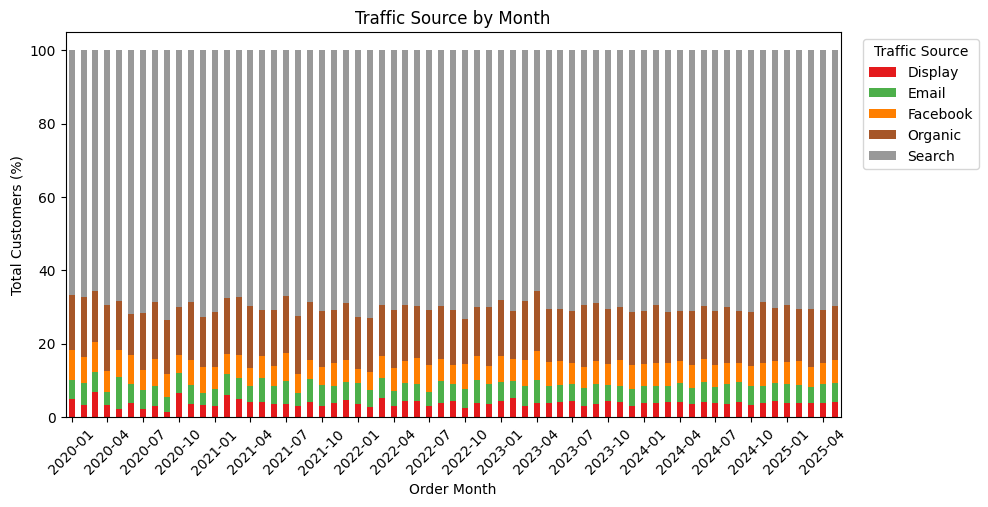

In [ ]:
# @title 2.4 About 70% users coming from search traffic, 15% from organic and 15% from other channels.
# @markdown **Key Insights:**
# @markdown <li> Search is a preferred channel for user with a significant contribution to the overall traffic.
# @markdown <li> Organic traffic is a strong secondary channel which showing a healthy level of brand awareness or relevant content discovery.
# @markdown <li> Other channels have a minor impact which might be due to budget or limited engagement.

# @markdown **Recommendations:**
# @markdown <li> Continue search optimization, deep dive into brands vs non-brands keywords and improve CPC and CAC.
# @markdown <li> Review the channel attribution to understand customer touch points.
# @markdown <li> Strengthen organic and other channels to improve engagement for diversification.

# Group customer by traffic sources per month
df_traffic = df.groupby(['order_month','traffic_source']).agg(
    total_user = ('user_id','nunique')
).reset_index()

# Reshape data to stack bar by percentage of total
df_traffic = df_traffic.pivot(index = 'order_month', columns = 'traffic_source', values = 'total_user')
df_traffic_pct = df_traffic.div(df_traffic.sum(axis=1), axis=0) * 100
df_traffic_pct.plot(kind='bar', stacked=True, figsize=(10,5), colormap='Set1')

# Format chart
xtick_labels = df_traffic.index
plt.xticks(ticks=range(0, len(xtick_labels), 3), labels=xtick_labels[::3], rotation=45)

plt.xlabel('Order Month')
plt.ylabel('Total Customers (%)')
plt.title('Traffic Source by Month')
plt.legend(title='Traffic Source', bbox_to_anchor=(1.02,1), loc="upper left")
plt.show()

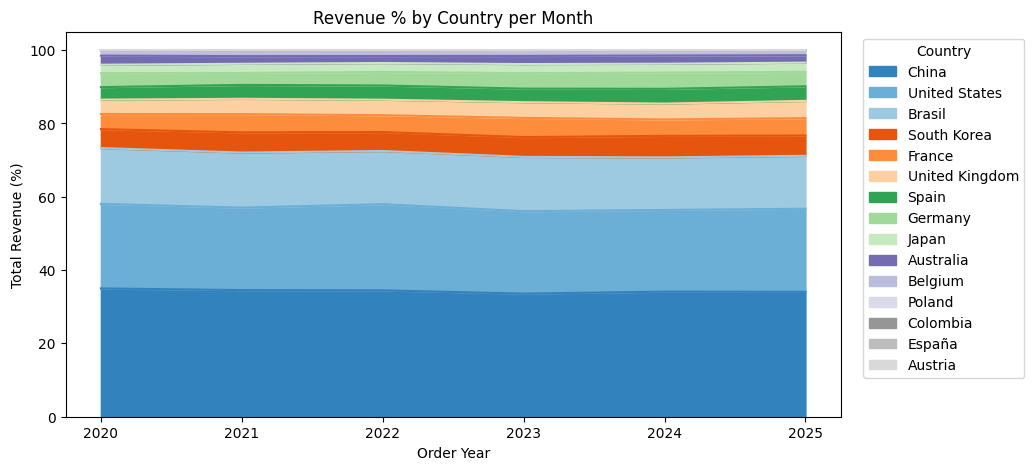

In [ ]:
# @title 2.5 About 75% of revenue is from the top-tier countries: China, US and Brasil.

# @markdown **Key Insights:**
# @markdown <li> Second-tier countries contributed 20% of total revenue (South Korea, France, UK, Spain and Germany).
# @markdown <li> Remaining 5% are from other countries.

# @markdown **Recommendations:**
# @markdown <li> Continue to focus on the top-tier countries.
# @markdown <li> Look for the opportunity to grow the second-tier countries.

# Get total revenue by country per month and sort by latest_year
sorted_country = df[df['order_year']==df['order_year'].max()].groupby('country')['order_price'].sum().sort_values(ascending=False).index.tolist()
country_rev = df.groupby(['order_year','country'])['order_price'].sum().reset_index()
country_rev = country_rev.pivot(index='order_year', columns='country', values='order_price')
country_rev = country_rev[sorted_country]

# Pivot data to monthly and percentage of total
country_rev_pct = country_rev.div(country_rev.sum(axis=1), axis=0) * 100
country_rev_pct.plot(kind='area', stacked=True, figsize=(10,5), colormap="tab20c")

# Format chart
plt.xlabel('Order Year')
plt.ylabel('Total Revenue (%)')
plt.title('Revenue % by Country per Month')
plt.legend(title='Country', bbox_to_anchor=(1.02,1), loc="upper left")
plt.show()

# **Analysis: 3. Inventory**

In [ ]:
# @title [Extract to data frame] Inventory data

%%bigquery df --project $project_id

DECLARE date_end DATE DEFAULT "2025-05-31";

SELECT DISTINCT FORMAT_DATE("%Y%m", year_month_start) AS year_month,
  SUM(IF(sold_at IS NOT NULL AND sold_at BETWEEN year_month_start AND year_month_end,cost,0))/((SUM(IF(product_avail_start=1,cost,0)) + SUM(IF(product_avail_end=1,cost,0))) / 2) AS inv_turnover_ratio,
  ((SUM(IF(product_avail_start=1,cost,0)) + SUM(IF(product_avail_end=1,cost,0))) / 2)/SUM(IF(sold_at IS NOT NULL AND sold_at BETWEEN year_month_start AND year_month_end,cost,0)) * 30 AS doh,
  SUM(IF(product_avail_end = 1, cost, NULL)) AS ttl_prod_on_hand,
  SUM(IF(product_avail_end = 1 AND days_on_hand <= 90, cost, NULL)) AS doh_3m,
  SUM(IF(product_avail_end = 1 AND days_on_hand BETWEEN 91 AND 180, cost, NULL)) AS doh_6m,
  SUM(IF(product_avail_end = 1 AND days_on_hand BETWEEN 181 AND 270, cost, NULL)) AS doh_9m,
  SUM(IF(product_avail_end = 1 AND days_on_hand BETWEEN 271 AND 365, cost, NULL)) AS doh_12m,
  SUM(IF(product_avail_end = 1 AND days_on_hand > 365, cost,NULL)) AS doh_above_12m
FROM (
  SELECT d.*,
      r.* EXCEPT(sold_at),
      IF(r.sold_at <= d.year_month_end, r.sold_at, NULL) AS sold_at,
      IF(r.created_at <= d.year_month_start AND (r.sold_at IS NULL OR r.sold_at > d.year_month_start),1,0) AS product_avail_start,
      IF(r.created_at <= d.year_month_end AND (r.sold_at IS NULL OR r.sold_at > d.year_month_end),1,0) AS product_avail_end,
      CASE WHEN r.created_at <= d.year_month_end AND (r.sold_at IS NULL OR r.sold_at > d.year_month_end) THEN DATE_DIFF(d.year_month_end,r.created_at,DAY)
        WHEN r.sold_at BETWEEN d.year_month_start AND d.year_month_end THEN DATE_DIFF(r.sold_at,r.created_at,DAY)
        ELSE 0
        END AS days_on_hand
  FROM (
    SELECT DISTINCT DATE_TRUNC(DATE(created_at),MONTH) AS year_month_start,
      LAST_DAY(DATE(created_at),MONTH) AS year_month_end,
    FROM `bigquery-public-data.thelook_ecommerce.inventory_items`
    WHERE DATE(created_at) BETWEEN DATE_SUB(date_end, INTERVAL 12 MONTH) AND date_end
  ) AS d
  CROSS JOIN (
    SELECT i.product_sku,
    i.cost,
    oi.sale_price,
    DATE(i.created_at) AS created_at,
    DATE(IFNULL(i.sold_at,oi.created_at)) AS sold_at
  FROM `bigquery-public-data.thelook_ecommerce.inventory_items` AS i
  LEFT JOIN `bigquery-public-data.thelook_ecommerce.order_items` AS oi ON oi.inventory_item_id = i.id
  WHERE oi.status NOT IN ('Cancelled', 'Returned')
  ) AS r
)
WHERE year_month_end >= created_at
GROUP BY 1
ORDER BY 1

Query is running:   0%|          |

Downloading:   0%|          |

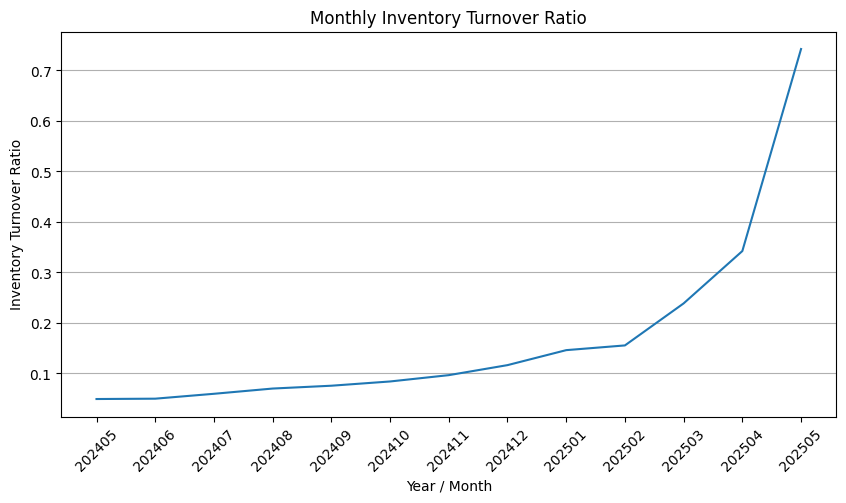

In [ ]:
# @title 3.1 Inventory Turnover Ratio significantly increased from 0.05 to 0.7, while Average Days on Hand (DoH) dropped from 600 to 40 days.

# @markdown **Key Insights:**
# @markdown <li> Massive growth in seen since early 2025, aligned with the growth in sales.
# @markdown <li> Much faster sell-through might put pressure on the inventory management.

# @markdown **Recommendations:**
# @markdown <li> Look into potential issue might be occur due to the massive changes.
# @markdown <li> Drill down into product-level analysis to understand factors that contribute to the massive growth.

plt.figure(figsize=(10,5))
plt.plot(df['year_month'], df['inv_turnover_ratio'])
plt.xticks(rotation=45)
plt.xlabel("Year / Month")
plt.ylabel("Inventory Turnover Ratio")
plt.title("Monthly Inventory Turnover Ratio")
plt.grid(axis='y')
plt.show()

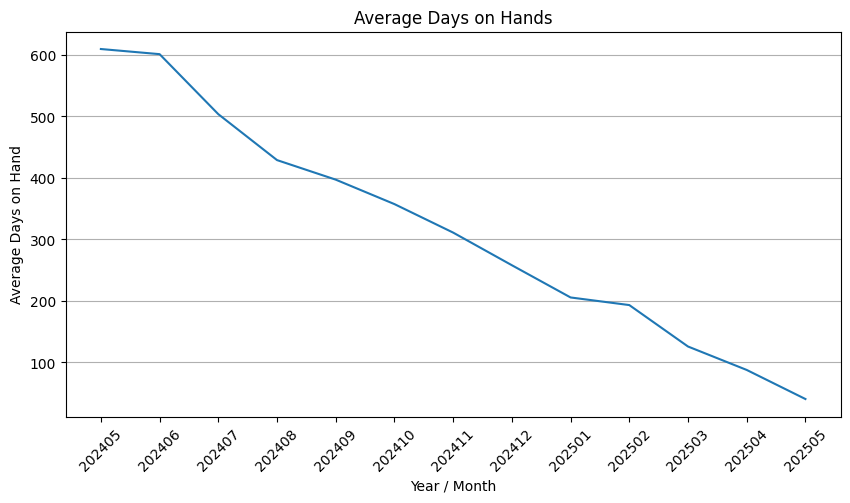

In [ ]:
# @title 3.2. Average Days on Hand (DoH) down significantly from 600 to 40 days.

plt.figure(figsize=(10,5))
plt.plot(df['year_month'], df['doh'])
plt.xticks(rotation=45)
plt.xlabel("Year / Month")
plt.ylabel("Average Days on Hand")
plt.title("Average Days on Hands")
plt.grid(axis='y')
plt.show()

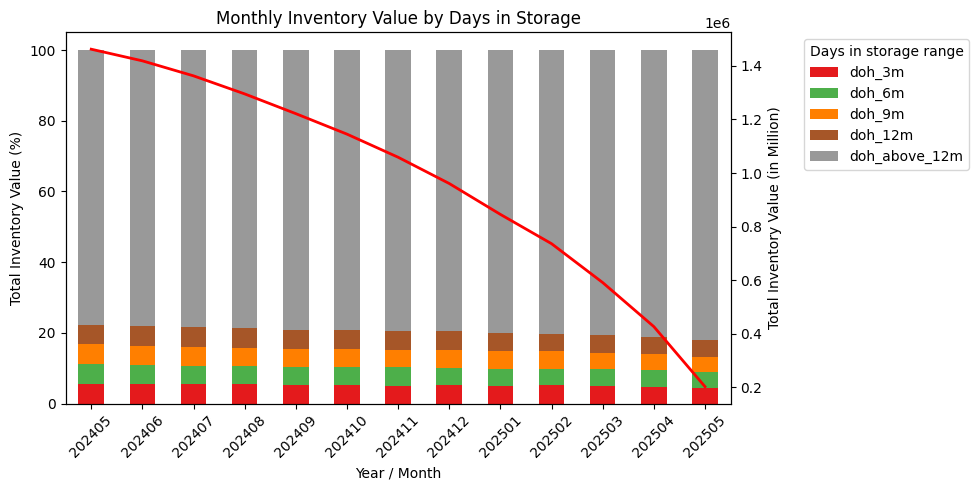

In [ ]:
# @title 3.3. Total inventory values has dropped significantly from 1.4M to 0.2M

# @markdown **Key Insights:**
# @markdown <li> About 80% of total inventory value has more than 180 days in storage.

# @markdown **Recommendations:**
# @markdown <li> Look into potential issue in supply chain and customer satisfaction.

# Define 2-axis chart size
fig, ax1 = plt.subplots(figsize=(10,5))

# Pivot data by order month and percentage of total per month
doh_prod = df.groupby('year_month')[['doh_3m','doh_6m','doh_9m','doh_12m','doh_above_12m']].sum()
doh_prod = doh_prod.div(doh_prod.sum(axis=1), axis=0) * 100

# Axis 1: % of doh per month
doh_prod.plot(kind='bar', stacked=True, ax=ax1, colormap='Set1')
ax1.legend(title='Days in storage range', bbox_to_anchor=(1.1, 1), loc='upper left')
ax1.set_ylabel('Total Inventory Value (%)')
ax1.set_xlabel('Year / Month')
xtick_labels = doh_prod.index
ax1.tick_params(axis='x',rotation=45)

# Axis 2: Total customers per month
ax2 = ax1.twinx()
ax2.plot(df['year_month'], df['ttl_prod_on_hand'], color='red', linewidth=2)
ax2.set_ylabel('Total Inventory Value (in Million)')

# Format chart
plt.title("Monthly Inventory Value by Days in Storage")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()